# Project: Advanced Lane Finding

## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
# Load nessesery modules
import cv2
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

In [28]:


# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


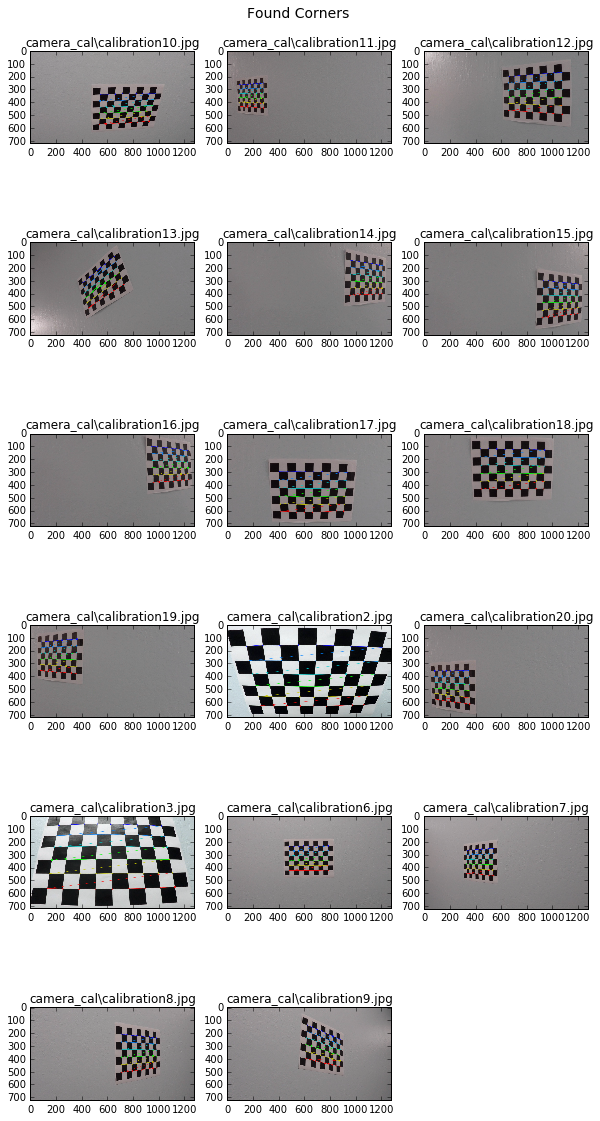

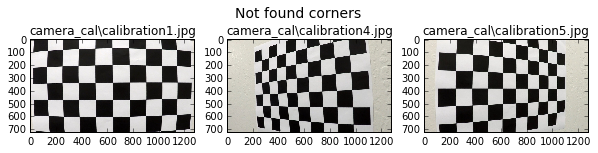

In [2]:
x_corners = 9 
y_corners = 6

objp = np.zeros((y_corners * x_corners,3), np.float32)
objp[:,:2] = np.mgrid[0:x_corners, 0:y_corners].T.reshape(-1,2)

objpoints = [] 
imgpoints = [] 

images = glob.glob('camera_cal/calibration*.jpg')

not_found = []

plt.figure(figsize=(10, 20))

plt.figtext(0.5,0.9,'Found Corners ', fontsize=14, ha='center')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (x_corners,y_corners), None)

    if ret:
        objpoints.append(objp)
        imgpoints.append(corners)
        plt.subplot(6, 3, len(imgpoints))
        cv2.drawChessboardCorners(img, (x_corners,y_corners), corners, ret)
        plt.imshow(img)
        plt.title(fname)
        
    else:
        not_found.append(fname)
plt.show()

plt.figure(figsize=(10, 20))

plt.figtext(0.5,0.56 ,'Not found corners ', fontsize=14, ha='center')
for i, p in enumerate(not_found):
    plt.subplot(1, 3, i+1)
    plt.imshow(mpimg.imread(p)) 
    plt.title(p)

plt.show()


## Apply a distortion correction to raw images.

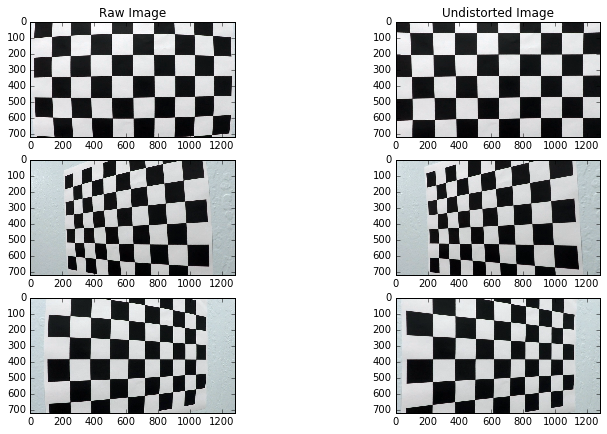

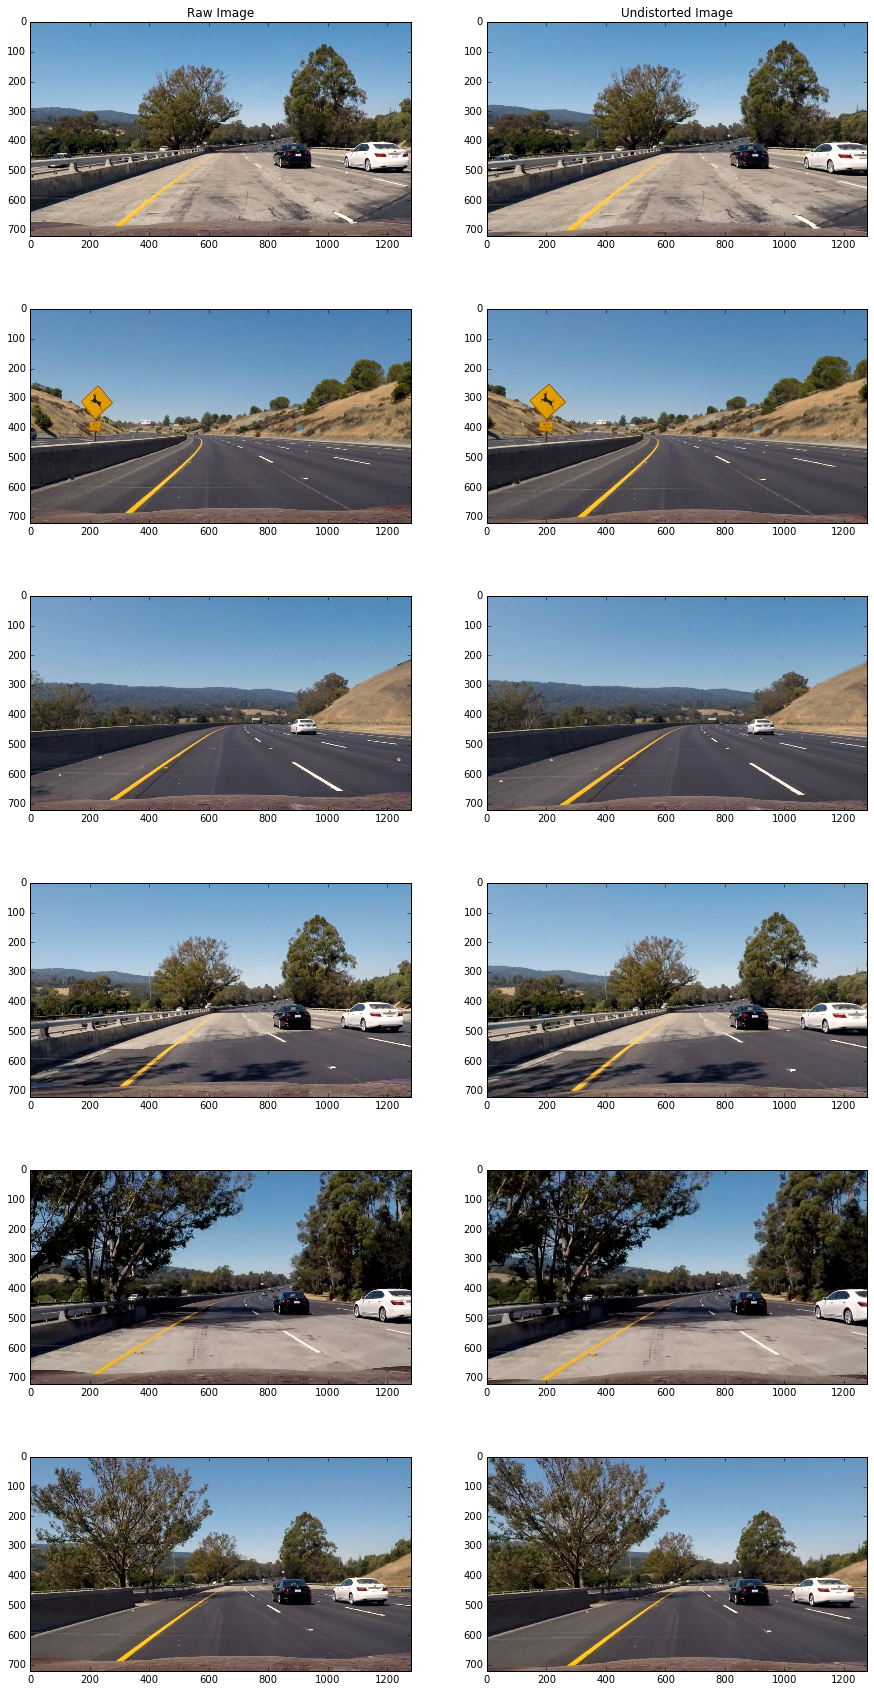

In [44]:
def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

img = []
for i in not_found:
    img.append(cv2.imread(i))

    
img_size = (img[0].shape[1], img[0].shape[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

plt.figure(figsize=(12, 7))

counter = 1
for i in img:
    plt.subplot(3, 2, counter)
    plt.imshow(i)
    if (counter == 1):
        plt.title("Raw Image")
    counter += 1 
    plt.subplot(3, 2, counter)
    plt.imshow(undistort_img(i, mtx, dist))
    if (counter == 2):
        plt.title("Undistorted Image")
    counter += 1
   
test_images_files = glob.glob('test_images/test*.jpg')
test_images = []
for i in test_images_files:
    test_images.append(cv2.imread(i))


plt.figure(figsize=(15, 30))
counter = 1

for i in test_images:
    plt.subplot(6, 2, counter)
    plt.imshow(cv2.cvtColor(i, cv2.COLOR_BGR2RGB))
    if (counter == 1):
        plt.title("Raw Image")
    counter += 1 
    plt.subplot(6, 2, counter)
    plt.imshow(cv2.cvtColor(undistort_img(i, mtx, dist), cv2.COLOR_BGR2RGB))
    if (counter == 2):
        plt.title("Undistorted Image")
    counter += 1

## Use color transforms, gradients, etc., to create a thresholded binary image.

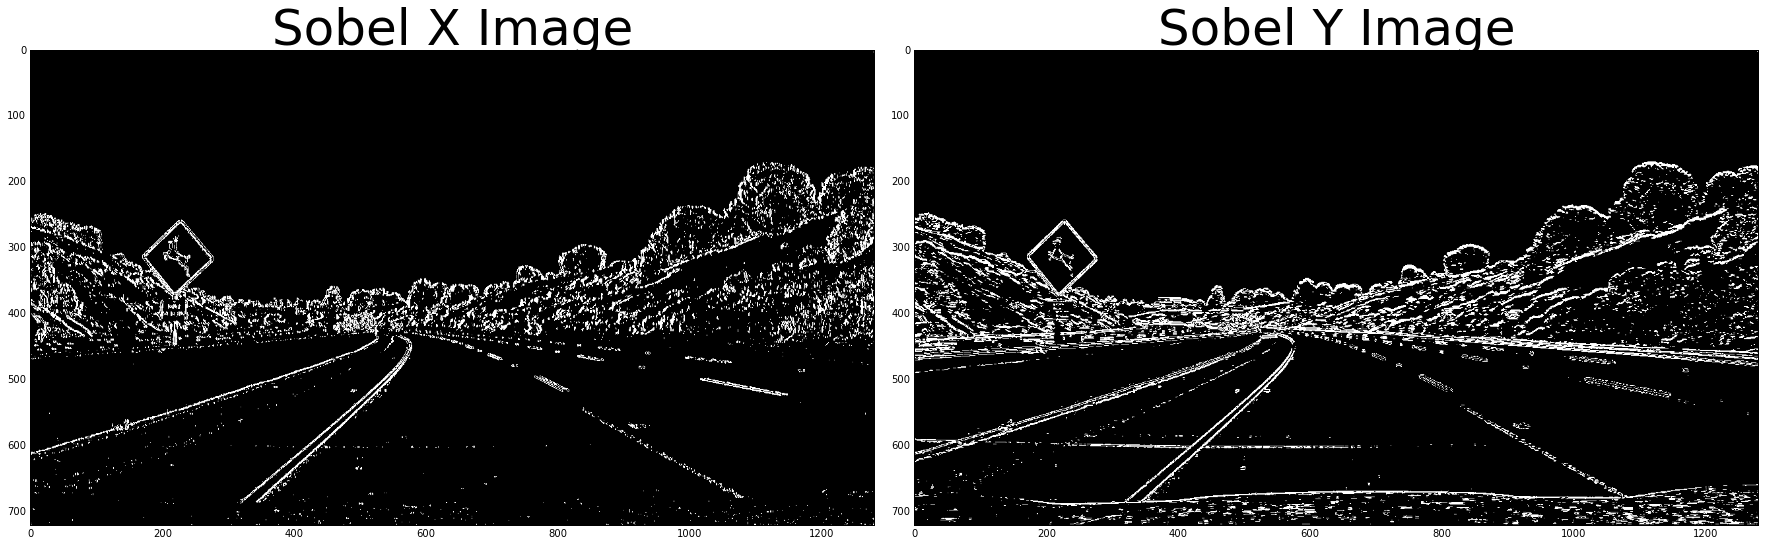

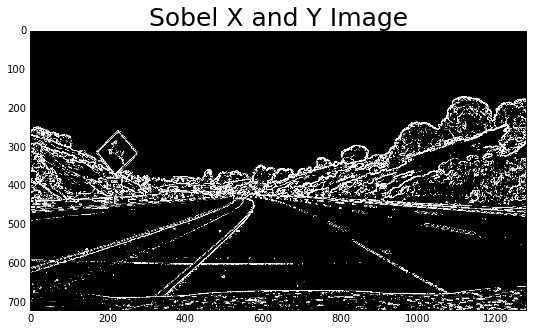

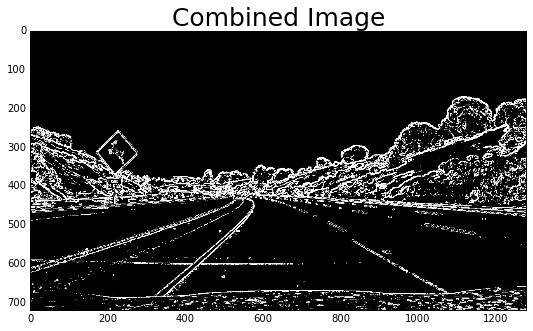

In [45]:
img = cv2.imread('test_images/test2.jpg')
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelxy = np.sqrt(sobelx ** 2 + sobely ** 2)
    scaled_sobel = np.uint8(255 * abs_sobelxy / np.max(abs_sobelxy))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return binary_output

## test results

abs_sobel_x_img = abs_sobel_thresh(img, 'x', 3, (20, 100))
abs_sobel_y_img = abs_sobel_thresh(img, 'y', 3, (20, 100))
abs_sobel_xy_img = mag_thresh(img, sobel_kernel=3, thresh=(20, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(abs_sobel_x_img, cmap='gray')
ax1.set_title('Sobel X Image', fontsize=50)
ax2.imshow(abs_sobel_y_img, cmap='gray')
ax2.set_title('Sobel Y Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.figure(figsize=(15, 5))
plt.imshow(abs_sobel_xy_img, cmap='gray')
plt.title('Sobel X and Y Image', fontsize=25)



gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
grady = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(20, 100))
mag_binary = mag_thresh(img, sobel_kernel=3, thresh=(20, 100))
dir_binary = dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2))


combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

plt.figure(figsize=(15, 5))
plt.imshow(combined, cmap='gray')
plt.title('Combined Image', fontsize=25)

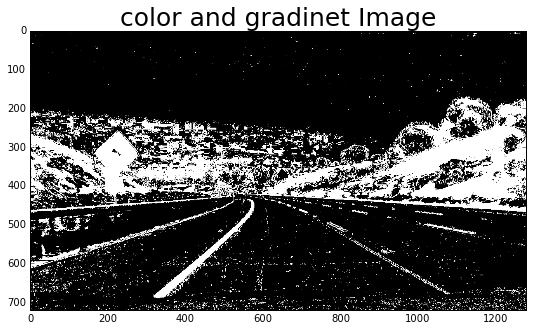

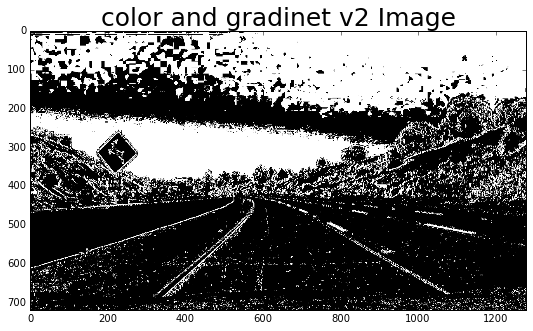

In [46]:
def apply_color_gradient_v2(img, normalized = True, thresh=(20,100), s_thresh=(220,255), b_thresh=(190,255)):
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100))
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    l_channel = l_channel*(255/np.max(l_channel))

    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= s_thresh[0]) & (l_channel <= s_thresh[1])] = 1
    
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    
    b_binary = np.zeros_like(lab_b)
    b_binary[((lab_b > b_thresh[0]) & (lab_b <= b_thresh[1]))] = 1


    combined_binary = np.zeros_like(gradx)
    combined_binary[(l_binary == 1) | (gradx == 1) | (b_binary == 1)] = 1    
    
    return combined_binary

    

def apply_color_gradient(img, normalized = True, xgrad_thresh=(20,100), s_thresh=(170,255)):
    
    if normalized == True:
        img[:, :, 0] = cv2.equalizeHist(img[:, :, 0])
        img[:, :, 1] = cv2.equalizeHist(img[:, :, 1])
        img[:, :, 2] = cv2.equalizeHist(img[:, :, 2])
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= xgrad_thresh[0]) & (scaled_sobel <= xgrad_thresh[1])] = 1

    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

img_color_gradient_normalized = apply_color_gradient(img)

plt.figure(figsize=(15, 5))
plt.imshow(img_color_gradient_normalized, cmap='gray')
plt.title('color and gradinet Image', fontsize=25)

img_color_gradient = apply_color_gradient_v2(img, normalized= True)
plt.figure(figsize=(15, 5))
plt.imshow(img_color_gradient, cmap='gray')
plt.title('color and gradinet v2 Image', fontsize=25)

## Apply a perspective transform to rectify binary image ("birds-eye view").

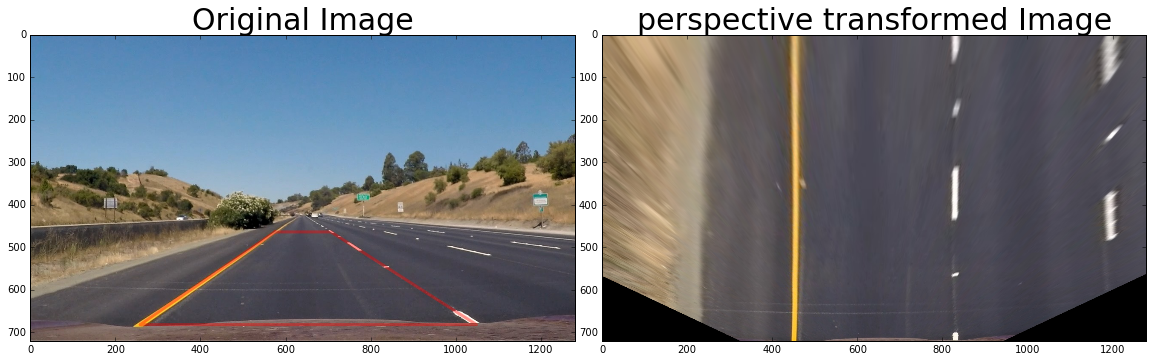

In [47]:
def perspective_transform(img, src, dst):
    h,w = img.shape[:2]
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

img = cv2.imread('test_images/straight_lines1.jpg')

h,w = img.shape[:2]

src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])

dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

exampleImg_unwarp, M, Minv = perspective_transform(img, src, dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)

ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]

ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_BGR2RGB))
ax2.set_title('perspective transformed Image', fontsize=30)


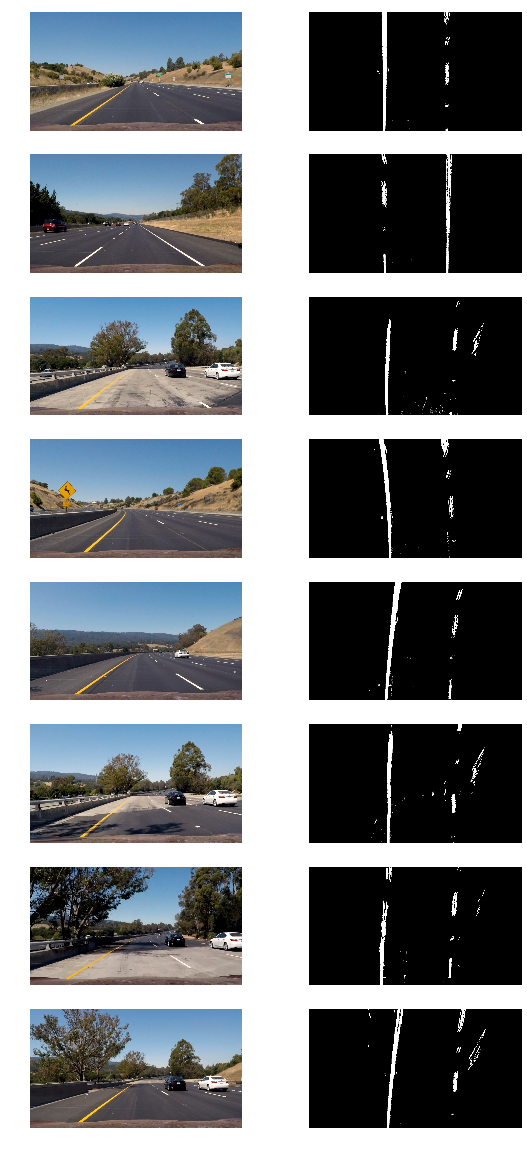

In [48]:
imshape = img_color_gradient.shape
vertices = np.array([[(0,imshape[0]),(550, 460), (790, 460), (imshape[1],imshape[0])]], dtype=np.int32)

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)

    if len(img.shape) > 2:
        channel_count = img.shape[2] 
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image


def processing_pipeline(img, mtx, dist, vertices, src, dst):
    
    img = undistort_img(img, mtx, dist)    
    
    img = apply_color_gradient_v2(img)
    
    img = region_of_interest(img, vertices)
    
    img, M, Minv = perspective_transform(img, src, dst)
    
    return img, Minv

images = glob.glob('./test_images/*.jpg')
                                          
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, _ = processing_pipeline(img, mtx, dist, vertices, src, dst)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

## Detect lane pixels and fit to find the lane boundary.

In [49]:
def sliding_windows_fit(img):
    
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    nwindows = 10
    window_height = np.int(img.shape[0]/nwindows)
    
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    margin = 80
    
    minpix = 40
    
    left_lane_inds = []
    right_lane_inds = []    
    rectangle_data = []

    for window in range(nwindows):
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)

    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data


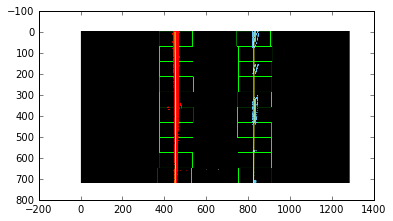

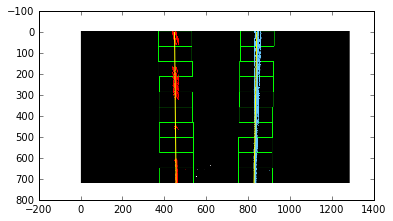

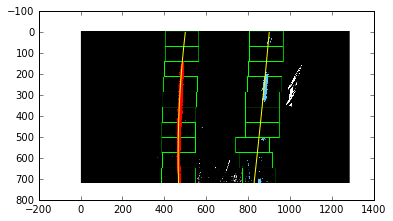

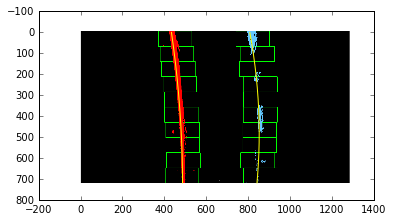

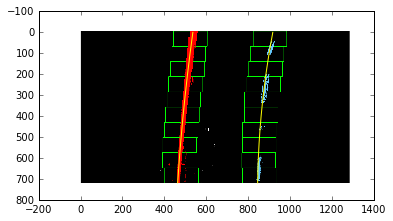

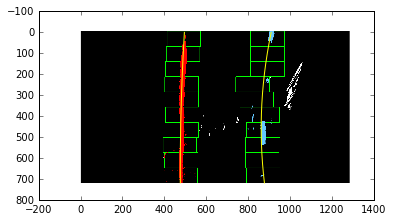

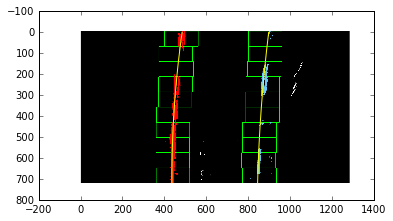

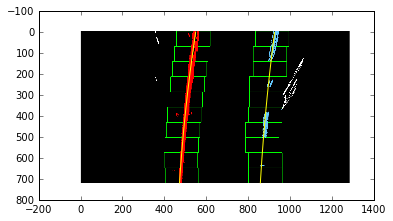

In [50]:
exampleImg = cv2.imread('./test_images/test2.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)

def processing_fit_poly(img, mtx, dist, vertices, src, dst):
    exampleImg_bin, Minv = processing_pipeline(img, mtx, dist, vertices, src, dst)
    
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_windows_fit(exampleImg_bin)

    h = exampleImg.shape[0]
    left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]


    rectangles = visualization_data[0]
    histogram = visualization_data[1]


    out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)

    ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    for rect in rectangles:

        cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
        cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 

    nonzero = exampleImg_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
    
    
    
    plt.figure()
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    
images = glob.glob('./test_images/*.jpg')

i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    processing_fit_poly(img, mtx, dist, vertices, src, dst)

In [10]:
def processing_fit_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
        
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

## Determine the curvature of the lane and vehicle position with respect to center.

In [51]:
def calc_curvature(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    
    ym_per_pix = 3.05/100
    xm_per_pix = 3.7/378
    
    left_curverad = 0
    right_curverad = 0
    center_dist = 0
    h = bin_img.shape[0]
    
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
        
    return left_curverad, right_curverad, center_dist

## Warp the detected lane boundaries back onto the original image.

In [61]:
def draw_lane_pipeline(img, mtx, dist, vertices, src, dst):
    
    binary_img, Minv = processing_pipeline(img, mtx, dist, vertices, src, dst)
    
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_windows_fit(binary_img)
    
    
    if left_fit is None or right_fit is None:
        return original_img
    
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    
    # calculate left and right lane x 
    ploty = np.linspace(0, h-1, num=h)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    
    result = cv2.addWeighted(img, 1, newwarp, 0.5, 0)
    
    return result, left_fit, right_fit, left_lane_inds, right_lane_inds

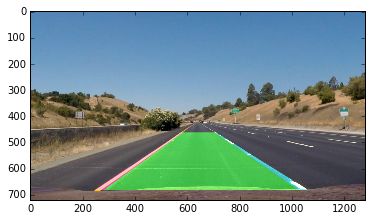

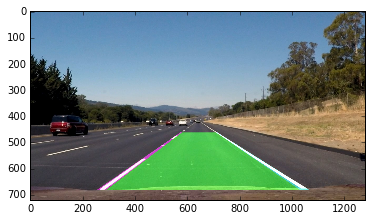

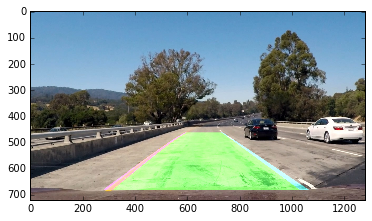

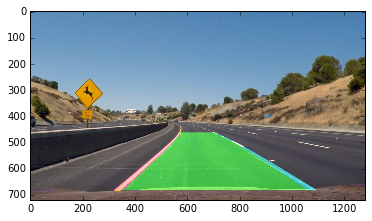

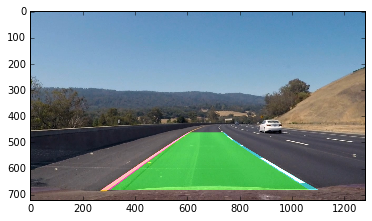

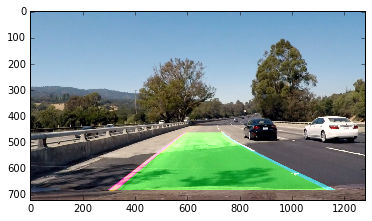

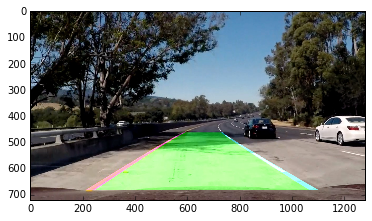

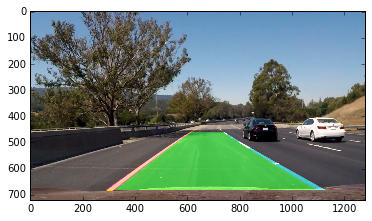

In [62]:
images = glob.glob('./test_images/*.jpg')

for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    res_img, left_fit, right_fit, left_lane_inds, right_lane_inds = draw_lane_pipeline(img, mtx, dist, vertices, src, dst)
    plt.figure()
    plt.imshow(res_img)
    


## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [63]:
def draw_info(img, curv_rad, center_dist):
    
    h = img.shape[0]
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = 'Radius of Curvature = ' + '{:04.2f}'.format(curv_rad) + '(m)'
    cv2.putText(img, text, (40,70), font, 1.5, (255,128,0), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(img, text, (40,120), font, 1.5, (255,128,0), 2, cv2.LINE_AA)
    return img



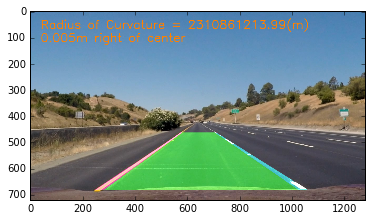

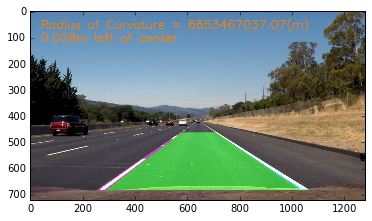

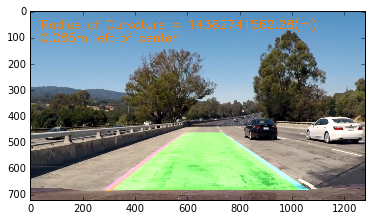

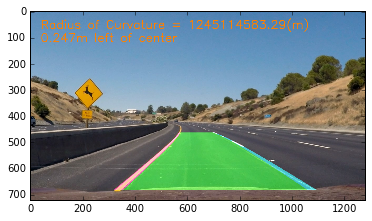

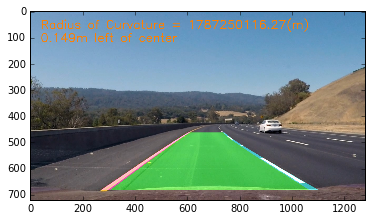

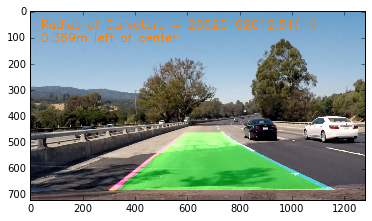

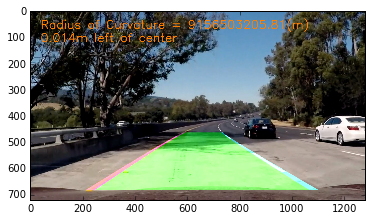

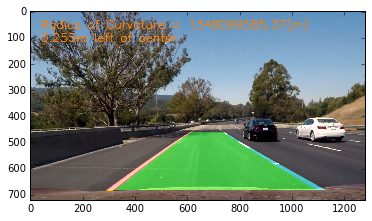

In [64]:
images = glob.glob('./test_images/*.jpg')

for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # combine all function has implemented 
    res_img, left_fit, right_fit, left_lane_inds, right_lane_inds = draw_lane_pipeline(img, mtx, dist, vertices, src, dst)
    left_curverad, right_curverad, center_dist = calc_curvature(res_img, left_fit, right_fit, left_lane_inds, right_lane_inds)
    
    res_img = draw_info(res_img, (left_curverad+right_curverad)/2, center_dist)
    
    plt.figure()
    plt.imshow(res_img)
    

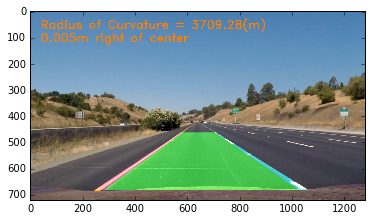

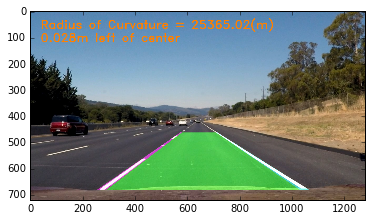

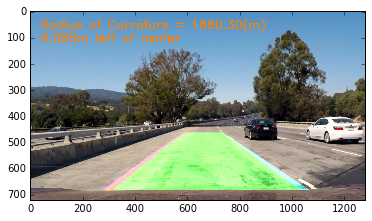

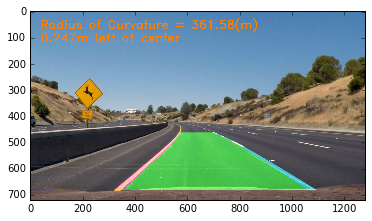

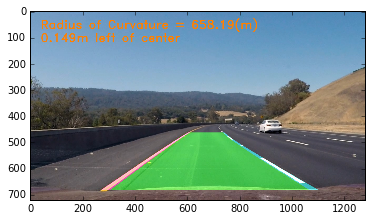

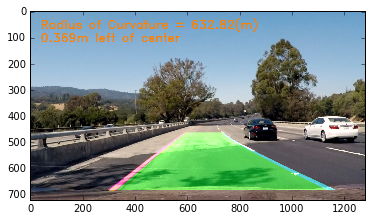

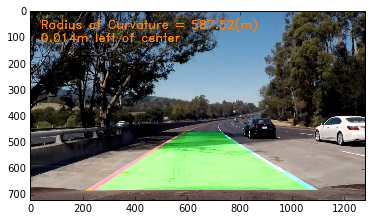

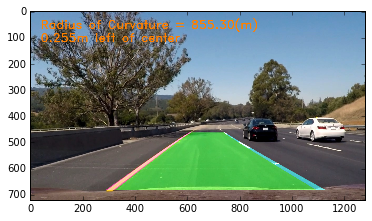

In [65]:
def lane_detection_pipeline():
    pass


def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist



def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

def hls_lthresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def pipeline(img):
    # Undistort
    img_undistort = undistort(img)
    
    # Perspective Transform
    img_unwarp, M, Minv = unwarp(img_undistort, src, dst)

    # Sobel Absolute (using default parameters)
    #img_sobelAbs = abs_sobel_thresh(img_unwarp)

    # Sobel Magnitude (using default parameters)
    #img_sobelMag = mag_thresh(img_unwarp)
    
    # Sobel Direction (using default parameters)
    #img_sobelDir = dir_thresh(img_unwarp)
    
    # HLS S-channel Threshold (using default parameters)
    #img_SThresh = hls_sthresh(img_unwarp)

    # HLS L-channel Threshold (using default parameters)
    img_LThresh = hls_lthresh(img_unwarp)

    # Lab B-channel Threshold (using default parameters)
    img_BThresh = lab_bthresh(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    return combined, Minv

def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    #print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist


def process_image(img):
    
    new_img = np.copy(img)
    #img_bin, Minv = pipeline(new_img)
    img_bin, Minv = processing_pipeline(img, mtx, dist, vertices, src, dst)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    #if not l_line.detected or not r_line.detected:
    #    l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    #else:
    #    l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
    l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)    
    
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    return img_out


for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    l_line = Line()
    r_line = Line()
    res_img = process_image(img)

    
    plt.figure()
    plt.imshow(res_img)